# Esercizio 2.2: Topic modelling

Il seguente esercizio consisterà nell'estrarre 3 topic da una lista di 30 documenti estratti da Wikipedia usando Sketch Engine

In particolare avremo i seguenti topic che cercheremo di estrarre:
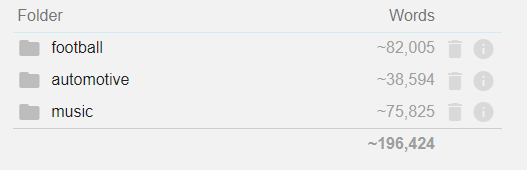

Dove per ogni topic abbiamo usato le seguenti pagine di Wikipedia:
<table><tr>
<td> 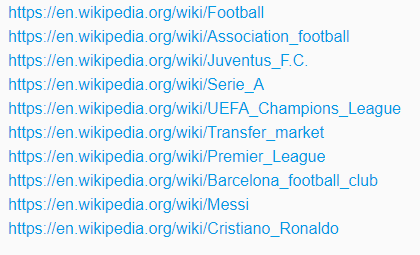 </td>
<td> 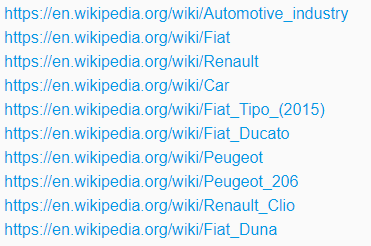 </td>
<td> 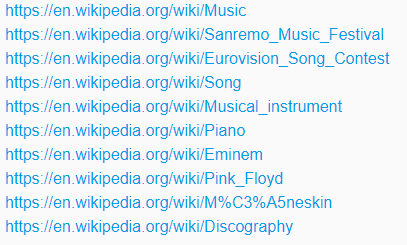 </td>
</tr></table>

Come si può notare dalla prima immagine c'è una differenza importante nel numero di parole tra i diversi topic quindi ci si aspetta che quello legato alle autovetture risulti più difficilmente individuabile dal programma

In [1]:
from nltk.corpus import stopwords
import os
import re
from pprint import pprint
# Carichiamo le stop words
stop_words = set(stopwords.words('english'))

def load_dataset(file):
    str = open(os.getcwd()+f'\\{file}.txt', 'r', encoding="utf8").read()
    list_document = []
    #extract all document
    docs = re.findall(r'<doc[^>]*(.*?)<\/doc>', str, re.DOTALL)
    #extract all sentence for document
    for doc in docs:
        list_document.append(''.join(re.findall(r'<p>(.*)</p>', doc)))
    return list_document

# list of document, each document is a string
corpus = load_dataset('corpus_2_2_big')

In [2]:
from gensim.models import CoherenceModel
import gensim

# Build the bigram and trigram models
#bigram = gensim.models.Phrases(corpus_sent, min_count=5, threshold=100)
#trigram = gensim.models.Phrases(bigram[corpus_sent], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
#bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def make_bigrams2(text):
    bigram = gensim.models.Phrases(corpus_sent, min_count=5)
    for idx in range(len(text)):
        for token in bigram[text[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                text[idx].append(token)
    return text

## Preprocessing

Come preprocessing si inizia con una regural expression per eliminare le nuove linee.

Segue una fase in cui filtriamo le stopwords, importate da nltk, e i simboli di punteggiatura.

In fine si è deciso di utilizzare la libreria di Spacy per effettuare un filtraggio sulle non-content words e allo stesso tempo 
estarne soltanto i Lemmi.

In [3]:
import spacy
from gensim.utils import simple_preprocess

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
       
def remove_stopwords_and_punct(texts):
    return [[word for word in simple_preprocess(str(doc),  deacc=True) if word not in stop_words] for doc in texts]

# load spacy corpus without parser and ner
nlp = spacy.load('en_core_web_lg', disable=['ner'])

# removing new line
corpus_sent = [re.sub(r'\s+', ' ', sent) for sent in corpus] 

# remove punctuations and stop words
corpus_sent = remove_stopwords_and_punct(corpus_sent)

corpus_sent = make_bigrams2(corpus_sent)
#corpus_sent = make_trigrams(corpus_sent)

# lemmatization
corpus_sent = lemmatization(corpus_sent)

## LDA

A questo punto possiamo iniziare ad applicare la libreria `gensim` per l'estrazione dei topic.

Iniziamo definendo il Dictionary passando il nostro testo processato, costruiamo la lista delle frequenze e passiamo il tutto in pasto all'algoritmo LDA 
con la chiamata ```LdaModel(dictionary, term frequency, numero topic)```

In [11]:
from gensim.corpora.dictionary import Dictionary
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from pprint import pprint
# Creation Dictionary
common_dictionary  = corpora.Dictionary(corpus_sent)  
#common_dictionary.filter_extremes(no_below=10, no_above=0.5)

# Term Document Frequency 
common_corpus  = [common_dictionary.doc2bow(text) for text in corpus_sent]  

# Train the model on the corpus.
lda = LdaModel(common_corpus, id2word=common_dictionary, num_topics=3)

pprint(lda.print_topics())

[(0,
  '0.009*"first" + 0.009*"country" + 0.008*"year" + 0.007*"goal" + '
  '0.007*"music" + 0.006*"car" + 0.006*"contest" + 0.006*"team" + 0.006*"time" '
  '+ 0.005*"season"'),
 (1,
  '0.011*"music" + 0.010*"goal" + 0.009*"first" + 0.008*"player" + '
  '0.008*"club" + 0.007*"football" + 0.007*"season" + 0.007*"play" + '
  '0.006*"year" + 0.006*"score"'),
 (2,
  '0.013*"club" + 0.010*"player" + 0.009*"football" + 0.007*"season" + '
  '0.007*"goal" + 0.006*"music" + 0.006*"play" + 0.006*"car" + 0.006*"time" + '
  '0.006*"team"')]


In [12]:
#!{sys.executable} -m pip install pyLDAvis
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda, common_corpus, common_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.004170  0.005898       1        1  59.910844
0      0.009901 -0.000589       2        1  21.993836
2     -0.005730 -0.005309       3        1  18.095320, topic_info=          Term        Freq       Total Category  logprob  loglift
156       club  534.000000  534.000000  Default  30.0000  30.0000
206    country  238.000000  238.000000  Default  29.0000  29.0000
708     player  515.000000  515.000000  Default  28.0000  28.0000
192    contest  177.000000  177.000000  Default  27.0000  27.0000
374   football  467.000000  467.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
833      score   46.711124  380.088066   Topic3  -5.5639  -0.3869
840     second   36.131522  224.652496   Topic3  -5.8208  -0.1179
411       game   40.502222  308.056040   Topic3  -5.7066  -0.3194
1005       use   37.488240  296.347863   Topic3  -5.7839  -0.3580
475    include   35.897436  260.157482   Topic3  -5.8273  -0.2711

[268 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1062      1  0.509385       academy
1062      2  0.127346       academy
1062      3  0.382039       academy
5966      1  0.262939      accredit
5966      2  0.525879      accredit
...     ...       ...           ...
6239      2  0.510346     year_cont
6239      3  0.255173     year_cont
6240      1  0.503074  year_contest
6240      2  0.503074  year_contest
6240      3  0.251537  year_contest

[527 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [ ]:
from LDAExplore_master.processdata.lda import LDAVisualModel
from LDAExplore_master.processdata import fileops

word_corpus = fileops.read_file('20_newsgroups/alt.atheism/53350')
lda = LDAVisualModel([word_corpus])
lda.create_word_corpus([word_corpus])
lda.train_lda(3)
topics = lda.get_lda_corpus()

print (topics)

In [ ]:
import sys
!{sys.executable} -m pip uninstall pyqtwebengine  install pyqtwebengine==5.12